In [11]:
import numpy as np
import os
from xml.etree import ElementTree

class XML_preprocessor(object):

    def __init__(self, data_path):
        self.path_prefix = data_path
        self.num_classes = 20
        self.data = dict()
        self._preprocess_XML()

    def _preprocess_XML(self):
        filenames = os.listdir(self.path_prefix)
        for filename in filenames:
            tree = ElementTree.parse(self.path_prefix + filename)
            root = tree.getroot()
            bounding_boxes = []
            one_hot_classes = []
            size_tree = root.find('size')
            width = float(size_tree.find('width').text)
            height = float(size_tree.find('height').text)
            for object_tree in root.findall('object'):
                for bounding_box in object_tree.iter('bndbox'):
                    xmin = float(bounding_box.find('xmin').text)/width
                    ymin = float(bounding_box.find('ymin').text)/height
                    xmax = float(bounding_box.find('xmax').text)/width
                    ymax = float(bounding_box.find('ymax').text)/height
                bounding_box = [xmin,ymin,xmax,ymax]
                bounding_boxes.append(bounding_box)
                class_name = object_tree.find('name').text
                one_hot_class = self._to_one_hot(class_name)
                one_hot_classes.append(one_hot_class)
            image_name = root.find('filename').text
            bounding_boxes = np.asarray(bounding_boxes)
            one_hot_classes = np.asarray(one_hot_classes)
            image_data = np.hstack((bounding_boxes, one_hot_classes))
            self.data[image_name] = image_data

    def _to_one_hot(self,name):
        one_hot_vector = [0] * self.num_classes
        if name == 'aeroplane':
            one_hot_vector[0] = 1
        elif name == 'bicycle':
            one_hot_vector[1] = 1
        elif name == 'bird':
            one_hot_vector[2] = 1
        elif name == 'boat':
            one_hot_vector[3] = 1
        elif name == 'bottle':
            one_hot_vector[4] = 1
        elif name == 'bus':
            one_hot_vector[5] = 1
        elif name == 'car':
            one_hot_vector[6] = 1
        elif name == 'cat':
            one_hot_vector[7] = 1
        elif name == 'chair':
            one_hot_vector[8] = 1
        elif name == 'cow':
            one_hot_vector[9] = 1
        elif name == 'diningtable':
            one_hot_vector[10] = 1
        elif name == 'dog':
            one_hot_vector[11] = 1
        elif name == 'horse':
            one_hot_vector[12] = 1
        elif name == 'motorbike':
            one_hot_vector[13] = 1
        elif name == 'person':
            one_hot_vector[14] = 1
        elif name == 'pottedplant':
            one_hot_vector[15] = 1
        elif name == 'sheep':
            one_hot_vector[16] = 1
        elif name == 'sofa':
            one_hot_vector[17] = 1
        elif name == 'train':
            one_hot_vector[18] = 1
        elif name == 'tvmonitor':
            one_hot_vector[19] = 1

        else:
            print('unknown label: %s' %name)

        return one_hot_vector

## example on how to use it
# import pickle
# data = XML_preprocessor('VOC2007/Annotations/').data
# pickle.dump(data,open('VOC2007.p','wb'))

In [12]:
import numpy as np
from random import shuffle
from scipy.misc import imread
from scipy.misc import imresize
from keras.applications.imagenet_utils import preprocess_input

class Generator(object):
    def __init__(self, gt, bbox_util,
                 batch_size, path_prefix,
                 train_keys, val_keys, image_size,
                 saturation_var=0.5,
                 brightness_var=0.5,
                 contrast_var=0.5,
                 lighting_std=0.5,
                 hflip_prob=0.5,
                 vflip_prob=0.5,
                 do_crop=True,
                 crop_area_range=[0.75, 1.0],
                 aspect_ratio_range=[3./4., 4./3.]):
        self.gt = gt
        self.bbox_util = bbox_util
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.train_keys = train_keys
        self.val_keys = val_keys
        self.train_batches = len(train_keys)
        self.val_batches = len(val_keys)
        self.image_size = image_size
        self.color_jitter = []
        if saturation_var:
            self.saturation_var = saturation_var
            self.color_jitter.append(self.saturation)
        if brightness_var:
            self.brightness_var = brightness_var
            self.color_jitter.append(self.brightness)
        if contrast_var:
            self.contrast_var = contrast_var
            self.color_jitter.append(self.contrast)
        self.lighting_std = lighting_std
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.do_crop = do_crop
        self.crop_area_range = crop_area_range
        self.aspect_ratio_range = aspect_ratio_range
        
    def grayscale(self, rgb):
        return rgb.dot([0.299, 0.587, 0.114])

    def saturation(self, rgb):
        gs = self.grayscale(rgb)
        alpha = 2 * np.random.random() * self.saturation_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha + (1 - alpha) * gs[:, :, None]
        return np.clip(rgb, 0, 255)

    def brightness(self, rgb):
        alpha = 2 * np.random.random() * self.brightness_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha
        return np.clip(rgb, 0, 255)

    def contrast(self, rgb):
        gs = self.grayscale(rgb).mean() * np.ones_like(rgb)
        alpha = 2 * np.random.random() * self.contrast_var 
        alpha += 1 - self.contrast_var
        rgb = rgb * alpha + (1 - alpha) * gs
        return np.clip(rgb, 0, 255)

    def lighting(self, img):
        cov = np.cov(img.reshape(-1, 3) / 255.0, rowvar=False)
        eigval, eigvec = np.linalg.eigh(cov)
        noise = np.random.randn(3) * self.lighting_std
        noise = eigvec.dot(eigval * noise) * 255
        img += noise
        return np.clip(img, 0, 255)
    
    def horizontal_flip(self, img, y):
        if np.random.random() < self.hflip_prob:
            img = img[:, ::-1]
            y[:, [0, 2]] = 1 - y[:, [2, 0]]
        return img, y
    
    def vertical_flip(self, img, y):
        if np.random.random() < self.vflip_prob:
            img = img[::-1]
            y[:, [1, 3]] = 1 - y[:, [3, 1]]
        return img, y
    
    def random_sized_crop(self, img, targets):
        img_w = img.shape[1]
        img_h = img.shape[0]
        img_area = img_w * img_h
        random_scale = np.random.random()
        random_scale *= (self.crop_area_range[1] -
                         self.crop_area_range[0])
        random_scale += self.crop_area_range[0]
        target_area = random_scale * img_area
        random_ratio = np.random.random()
        random_ratio *= (self.aspect_ratio_range[1] -
                         self.aspect_ratio_range[0])
        random_ratio += self.aspect_ratio_range[0]
        w = np.round(np.sqrt(target_area * random_ratio))     
        h = np.round(np.sqrt(target_area / random_ratio))
        if np.random.random() < 0.5:
            w, h = h, w
        w = min(w, img_w)
        w_rel = w / img_w
        w = int(w)
        h = min(h, img_h)
        h_rel = h / img_h
        h = int(h)
        x = np.random.random() * (img_w - w)
        x_rel = x / img_w
        x = int(x)
        y = np.random.random() * (img_h - h)
        y_rel = y / img_h
        y = int(y)
        img = img[y:y+h, x:x+w]
        new_targets = []
        for box in targets:
            cx = 0.5 * (box[0] + box[2])
            cy = 0.5 * (box[1] + box[3])
            if (x_rel < cx < x_rel + w_rel and
                y_rel < cy < y_rel + h_rel):
                xmin = (box[0] - x_rel) / w_rel
                ymin = (box[1] - y_rel) / h_rel
                xmax = (box[2] - x_rel) / w_rel
                ymax = (box[3] - y_rel) / h_rel
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(1, xmax)
                ymax = min(1, ymax)
                box[:4] = [xmin, ymin, xmax, ymax]
                new_targets.append(box)
        new_targets = np.asarray(new_targets).reshape(-1, targets.shape[1])
        return img, new_targets
    
    def generate(self, train=True):
        while True:
            if train:
                shuffle(self.train_keys)
                keys = self.train_keys
            else:
                shuffle(self.val_keys)
                keys = self.val_keys
            inputs = []
            targets = []
            for key in keys:            
                img_path = self.path_prefix + key
                img = imread(img_path).astype('float32')
                y = self.gt[key].copy()
                if train and self.do_crop:
                    img, y = self.random_sized_crop(img, y)
                img = imresize(img, self.image_size).astype('float32')
                if train:
                    shuffle(self.color_jitter)
                    for jitter in self.color_jitter:
                        img = jitter(img)
                    if self.lighting_std:
                        img = self.lighting(img)
                    if self.hflip_prob > 0:
                        img, y = self.horizontal_flip(img, y)
                    if self.vflip_prob > 0:
                        img, y = self.vertical_flip(img, y)
                y = self.bbox_util.assign_boxes(y)
                inputs.append(img)                
                targets.append(y)
                if len(targets) == self.batch_size:
                    tmp_inp = np.array(inputs)
                    tmp_targets = np.array(targets)
                    inputs = []
                    targets = []
                    yield preprocess_input(tmp_inp), tmp_targets

In [13]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import pickle

from SSD300.ssd_v2 import SSD300v2
from SSD300.ssd_training import MultiboxLoss
from SSD300.ssd_utils import BBoxUtility

from get_data_from_XML import XML_preprocessor
from generator import Generator

voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1
input_shape = (300, 300, 3)

model = SSD300v2(input_shape, num_classes=NUM_CLASSES)

loss = MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss
model.compile(optimizer='Adadelta', loss=loss)

In [14]:
priors = pickle.load(open('./SSD300/prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [15]:
pascal_voc_07_parser = XML_preprocessor(data_path='./VOC2007/Annotations/')
# len(pascal_voc_07_parser.data) = 5011

# pascal_voc_07_parser.data['000007.jpg']
# array([[ 0.282     ,  0.15015015,  1.        ,  0.99099099,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ]])

keys = list(pascal_voc_07_parser.data.keys())
train_num = int(0.7 * len(keys))
train_keys = keys[:train_num]
val_keys = keys[train_num:]

gen = Generator(gt=pascal_voc_07_parser.data, bbox_util=bbox_util,
                 batch_size=16, path_prefix='./VOC2007/JPEGImages/',
                 train_keys=train_keys, val_keys=val_keys, image_size=(300, 300))

In [16]:

RUN = RUN + 1 if 'RUN' in locals() else 1

LOG_DIR = '/output/training_logs/run{}'.format(RUN)
LOG_FILE_PATH = LOG_DIR + '/checkpoint-{epoch:02d}-{val_loss:.4f}.hdf5'

EPOCHS = 5

tensorboard = TensorBoard(log_dir=LOG_DIR, write_images=True)
checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit_generator(generator=gen.generate(True), steps_per_epoch=int(gen.train_batches / 4),
                              validation_data=gen.generate(False), validation_steps=int(gen.val_batches / 4),
                              epochs=EPOCHS, verbose=1, callbacks=[tensorboard, checkpoint, early_stopping])

C:\Users\Dell\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5


KeyboardInterrupt: 

In [17]:
model.load_weights('./PASCAL_VOC_SSD300_weight_checkpoint-epoch-16-loss-3.3392.hdf5', by_name=True)

In [29]:
from keras.preprocessing import image
from scipy.misc import imread
from keras.applications.imagenet_utils import preprocess_input
import numpy as np

files = ('fish-bike.jpg', 'cat.jpg', 'boys.jpg', 'car_cat.jpg', 'car_cat2.jpg','176301632.jpg','xzy.jpg','my.jpeg')

inputs = []
images = []
for f in files:
    f = "./pics/{}".format(f)
    img = image.load_img(""+f, target_size=(300, 300))
    img = image.img_to_array(img)
    
    images.append(imread(f))
    inputs.append(img.copy())

inputs = preprocess_input(np.array(inputs))

preds = model.predict(inputs, batch_size=1, verbose=1)
# preds.shape (5, 7308, 33)

results = bbox_util.detection_out(preds)
# type(results): list, len(results): 5, len(result[0]): 200, results[0].shape: (200, 6)

8/8 [==============================] - 33s 4s/step


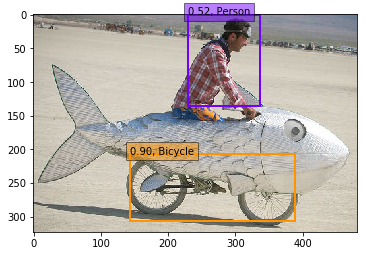

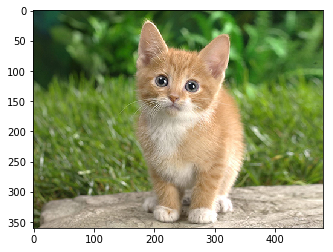

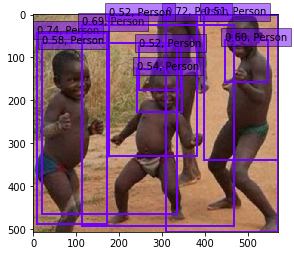

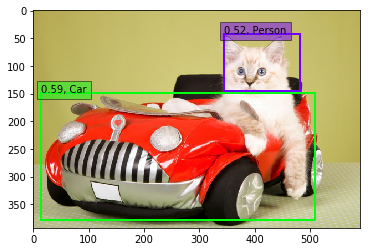

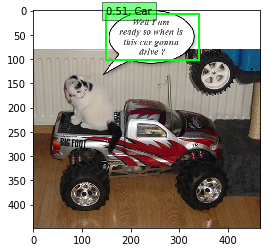

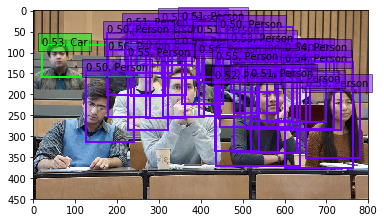

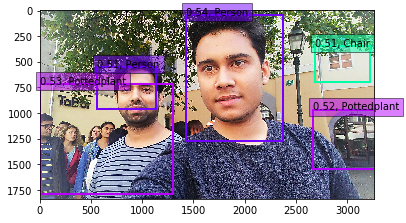

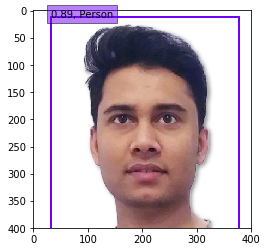

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.5]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()